# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#generate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
def CosineDist(a,b):
    result = a.dot(b)
    var = np.linalg.norm(a)*np.linalg.norm(b)
    if var > 0:
        return result/var
    else:
        return result

In [4]:
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

In [5]:
def getTopN(movie_id,D,N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [6]:
epsilon = 0.000000001

def eucDistance(a,b):
    return np.linalg.norm(a-b) + epsilon

eD = np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            eD[i,j]=eucDistance(R[:,i],R[:,j])
np.save("movie_dist",eD)

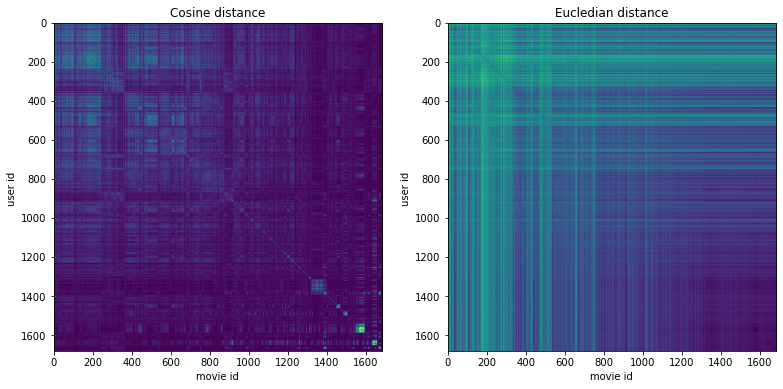

In [7]:
#import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 20))
ax1=fig.add_subplot(1, 3, 1)
plt.xlabel('movie id')
plt.ylabel('user id ')
ax1.title.set_text('Cosine distance')
plt.imshow(D)
ax2= fig.add_subplot(1, 3, 2)
plt.xlabel('movie id')
plt.ylabel('user id ')
ax2.title.set_text('Eucledian distance')
plt.imshow(eD)
plt.show()

### Compare results:

In [8]:
#split train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

In [9]:
#cos distance
cos_dis=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            cos_dis[i,j]=CosineDist(R_train[:,i],R_train[:,j])
            
np.save("movie_cos_dis",cos_dis)

In [10]:
#eucledian distance
euc_dis=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            euc_dis[i,j]=eucDistance(R_train[:,i],R_train[:,j])
            
np.save("movie_euc_dis",euc_dis)

In [11]:
test_cos=test_Score(cos_dis,R_test)
test_eD=test_Score(euc_dis,R_test)

print('Mean scores of cosine dist: ', np.mean(test_cos))
print('Mean scores of euclidean dist: ', np.mean(test_eD))

Mean scores of cosine dist:  2.1894736842105265
Mean scores of euclidean dist:  1.4509473684210528


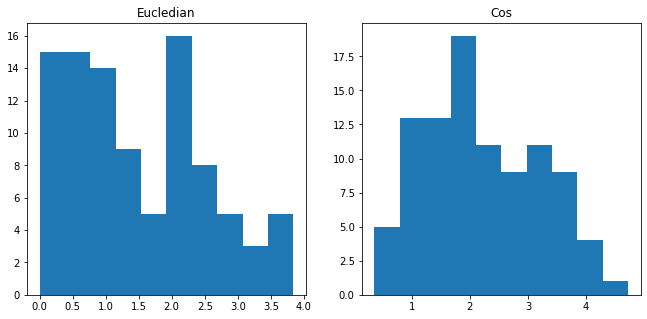

In [12]:
fig=plt.figure(figsize=(17, 5))
ax1=fig.add_subplot(1, 3, 1)
ax1.title.set_text('Eucledian')
plt.hist(test_eD)
ax2= fig.add_subplot(1, 3, 2)
ax2.title.set_text('Cos')
plt.hist(test_cos)
plt.show()

## Result:
Cosine distance measure is better than the eucledian distance.

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

### Random recommendations

In [13]:
#random recommendations - methods                  

def Score_byId_rand(Test):
    mov_id = np.random.randint(np.shape(D)[0], size=5)  
    mov_titel = getNameByID(mov_id)
    mov_score = Test[mov_id]
    return mov_id, mov_titel, mov_score, np.mean(mov_score)

def testRandScore(R_test):
    Scores=[]
    for i in range(R_test.shape[0]):
        Score=0
        Top = np.argsort(R_test[i])[-5:]
        for x in Top:
            res_id, res_title, res_score, av_score = Score_byId_rand(R_test[i])
            Score+=av_score
        Scores.append(Score/(5))
    return Scores

In [14]:
# random recommendations - test
test_rand = testRandScore(R_test)
print('mean score of random cosine:',np.mean(test_rand))

mean score of random cosine: 0.23578947368421052




### top 5 movies

In [15]:
# recommending the top 5 movies over all users - methods

def top5():
    A=np.zeros(np.shape(movies)[0])
    for i in range(0,np.shape(movies)[0]):
        A[i]=np.mean(R[:,i])
        
    return A.argsort()[-5:]

def ScoreByTop5(Test):
    mov_id = top5() 
    mov_title = getNameByID(mov_id)
    mov_score = Test[mov_id]
    return mov_id, mov_title, mov_score, np.mean(mov_score)

def TestTop5(R_test):
    Scores=[]
    for i in range(R_test.shape[0]):
        ScoreUser=0
        Top = np.argsort(R_test[i])[-5:]
        for e in Top:
            res_id, res_title, res_score, av_score = ScoreByTop5(R_test[i])
            ScoreUser+=av_score
        Scores.append(ScoreUser/(5))
    return Scores

In [16]:
print("Top five movies:", "\n")
for x in top5():
    print(x,"-",getNameByID(x))


Top five movies: 

173 - Raiders of the Lost Ark (1981)
257 - Contact (1997)
180 - Return of the Jedi (1983)
99 - Fargo (1996)
49 - Star Wars (1977)


In [17]:
# recommending the top 5 movies over all users - test
test_top=TestTop5(R)
print('mean score of top 5:',np.mean(test_top))

mean score of top 5: 2.206998939554613


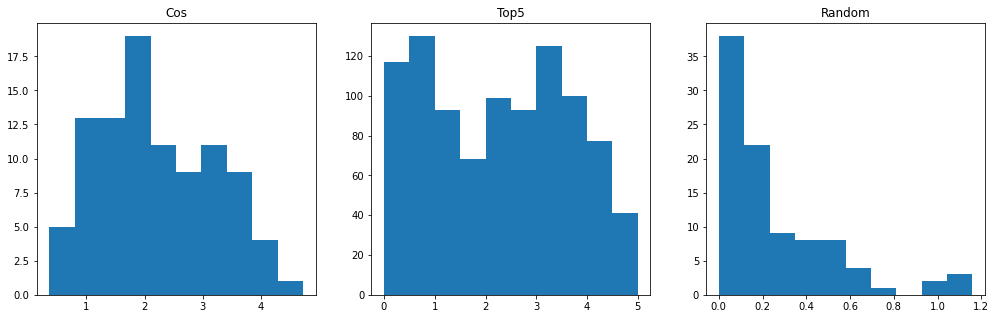

In [18]:
fig=plt.figure(figsize=(17, 5))
ax1=fig.add_subplot(1, 3, 1)
ax1.title.set_text('Cos')
plt.hist(test_cos)
ax2=fig.add_subplot(1, 3, 2)
ax2.title.set_text('Top5')
plt.hist(test_top)
ax3= fig.add_subplot(1, 3, 3)
ax3.title.set_text('Random')
plt.hist(test_rand)

plt.show()

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [19]:
U,S,V = np.linalg.svd(D)
D.shape, U.shape, S.shape, V.shape

((1682, 1682), (1682, 1682), (1682,), (1682, 1682))

In [20]:
np.allclose(D, np.dot(U[:1682,:]* S, V)) 

True

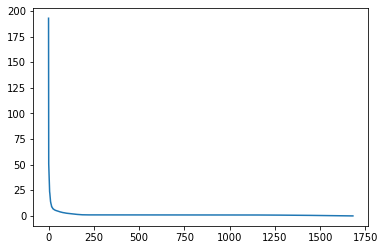

In [21]:
plt.plot(S)
plt.show()

In [22]:
cut = 70
d_new = np.dot(U[:,:cut] * S[:cut], V[:cut,:])
d_new

array([[ 0.67684717,  0.40228633,  0.33257056, ..., -0.00301943,
         0.053107  ,  0.02531966],
       [ 0.40228633,  0.63938312,  0.27789973, ...,  0.00512791,
         0.07822039,  0.04915136],
       [ 0.33257056,  0.27789973,  0.50531545, ...,  0.00782167,
        -0.00661928,  0.06745353],
       ...,
       [-0.00301943,  0.00512791,  0.00782167, ...,  0.64535452,
        -0.02336441,  0.02253868],
       [ 0.053107  ,  0.07822039, -0.00661928, ..., -0.02336441,
         0.37097536,  0.03336579],
       [ 0.02531966,  0.04915136,  0.06745353, ...,  0.02253868,
         0.03336579,  0.14641797]])

In [23]:
test_new= test_Score(d_new,R_test)
print("Mean score cos:",np.mean(test_cos), "Mean score cos new:",np.mean(test_new))

Mean score cos: 2.1894736842105265 Mean score cos new: 2.8753684210526314


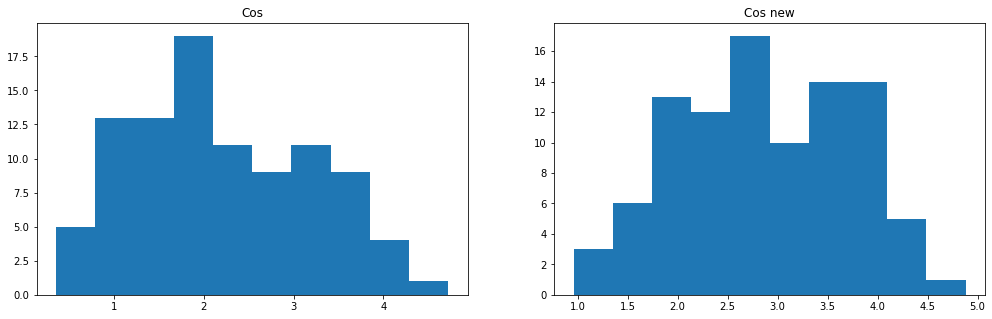

In [24]:
fig=plt.figure(figsize=(17, 5))
ax1=fig.add_subplot(1, 2, 1)
ax1.title.set_text('Cos')
plt.hist(test_cos)
ax2= fig.add_subplot(1, 2, 2)
ax2.title.set_text('Cos new')
plt.hist(test_new)
plt.show()